<a href="https://colab.research.google.com/github/Jinqiao-Li/multi_agent_reflection/blob/compacted_three_agents/3_agents_version/Create_3_analysts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   Author: Jinqiao Li
*   Date: 15.04.2025

--------------------------------

*   Middle agents (analysts) number: **3**
*   Reasoning in the middle (judgements): **Yes/No**
*   Time (for one refllection text): around **2-5s**
*   f1 score: ...

Parameters:
*   Model: gpt-4.1-mini
*   topic for analysts group: No
*   default *course_name*: Independent Study
*   default *topic* value: General Reflection



# Setting Environment

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [2]:
import os, getpass
from google.colab import userdata
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import operator
from typing import List, Annotated, Dict
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import pickle
from langgraph.constants import Send
import json
from typing import Dict, Any
from IPython.display import Image
from langgraph.graph import END, StateGraph, START
import warnings


In [3]:
# Ignore the specific Pydantic warning
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pydantic")


os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')

# LLM
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

## Prompts with middle reasoning

Analysts give both grades and judgements for each dimension.


In [4]:
# import prompts used for judgements and final feedback generation
from analysts_judgements_instruction import judgement_instruction
from final_feedback_instrction import final_feedback_instruction

## Testing prompts without middle reasoning.

Analysts only give grade for each dimension, no judgements.

In [4]:
from analysts_no_judgements import judgement_instruction
from final_feedback_instrction import final_feedback_instruction

# Module Structure

In [5]:

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    step_role: str = Field(
        description="Specific step of Gibbs’ Cycle assigned to the analyst",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.step_role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class FinalFeedback(BaseModel):
    is_reflection:int
    grades: Dict[str, int] = Field(..., description="Grades for each step of Gibbs' Cycle.")
    feedback: str = Field(..., description="Overall feedback on the reflection.")

class OverallState(TypedDict):
    topic: str
    reflection_input:str
    question:str
    course_name:str
    analysts: List[Analyst] # Analyst asking questions
    judgements: Annotated[list, operator.add]
    final_summarized_output: str


class JudgementState(TypedDict):
    analyst:Analyst
    course_name: str = Field(..., description="Name of the course relevant to the reflection.")
    question: str = Field(..., description="The specific question prompting the reflection.")
    reflection_input: str

class Judgement(BaseModel):
    judgement: str = Field(None, description="Detailed feedback for the step.")



In [12]:

def get_analysts(state: OverallState):

    topic=state["topic"]
    with open('three_analyst_values.pickle', 'rb') as file:
      analysts = pickle.load(file)

    #analysts = loaded_dict[topic]
    # Write the list of analysis to state
    return {"analysts": analysts}


def continue_to_judgements(state: OverallState):
    return [Send("generate_judgement", {"analyst": a,
                                        "reflection_input": state["reflection_input"],
                                        "question":state["question"],
                                        "course_name":state["course_name"],
                                        }) for a in state["analysts"]]


def generate_judgement(state: JudgementState):
    # Get state
    analyst = state["analyst"]
    course_name = state["course_name"]
    question = state["question"]
    reflection_input = state["reflection_input"]

    # Generate judgement for specific reflection text
    system_message = judgement_instruction.format(persona=analyst.persona,
                                                   step_role=analyst.step_role,
                                                   course_name=course_name,
                                                   question=question,
                                                   reflection_input=reflection_input)
    structured_llm = llm.with_structured_output(Judgement)
    response = structured_llm.invoke([SystemMessage(content=system_message),
                                                             HumanMessage(content=reflection_input)])
    return {"judgements": [response.judgement]}


def final_feedback(state: OverallState):

    judgements = "\n\n".join(state["judgements"])
    prompt = final_feedback_instruction.format(topic=state["topic"],
                                               reflection_input=state['reflection_input'],
                                               analysts_judgments=judgements,
                                               course_name=state["course_name"],
                                               question=state["question"],)
    response = llm.with_structured_output(FinalFeedback, method="json_mode").invoke(prompt)
    return {"final_summarized_output": [response.model_dump()]}

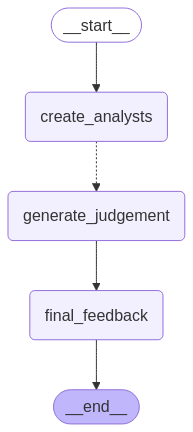

In [13]:
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("create_analysts", get_analysts)
graph.add_node("generate_judgement", generate_judgement)
graph.add_node("final_feedback", final_feedback)
graph.add_edge(START, "create_analysts")
graph.add_conditional_edges("create_analysts", continue_to_judgements, ["generate_judgement"])
graph.add_edge("generate_judgement", "final_feedback")
graph.add_edge("final_feedback", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [14]:
# this topic term "General Reflection" already saved in the analyst pickle file
def analyze_reflection(topic="General Reflection", reflection_input=None, course_name="Independent Study", question=None):
    generated_messages = []
    for s in app.stream({"topic": topic,
                         "reflection_input": reflection_input,
                         "course_name": course_name,
                         "question": question
                        }):
        generated_messages.append(s)
    result = generated_messages[-1].get('final_feedback').get('final_summarized_output')[0]
    return result

# Testing on One example

In [15]:
import pandas as pd

path = '/content/drive/MyDrive/BFH/rflect/data/gold_standard/scaled_50/gold_50_major_voting.xlsx'
df_50 = pd.read_excel(path)

In [16]:
df_50.iloc[0]['Text']

'I did a lot of individual work including extra work and completed my studies very well for this week.'

In [17]:

analyze_reflection(reflection_input=df_50.iloc[0]['Text'], question=df_50.iloc[0]['Question'])

{'is_reflection': 0,
 'grades': {'Experience': 0, 'Analysis': 0, 'Action': 0},
 'feedback': 'Your response does not seem to be a reflection. Try describing an experience, explaining how it affected you, and what lessons you took from it. Reflect on your feelings during the process and consider what you might do differently next time to deepen your learning.'}

# Testing on 50 dataset


In [18]:
df_50['results_41mini'] = df_50.apply(lambda row:analyze_reflection(
                                                   reflection_input=row['Text'], question=row['Question']), axis=1)


# post-processing

In [19]:
df_results_41mini = pd.DataFrame(columns=['is_reflection', 'Experience', 'Analysis', 'Action', 'feedback'])
# Parse the results and populate the new dataframe
for index, row in df_50.iterrows():
    result = row['results_41mini']
    grades = result.get('grades', {})  # Handle missing grades gracefully
    new_row = {
        'is_reflection': result.get('is_reflection'),
        'Experience': grades.get('Experience'),
        'Analysis': grades.get('Analysis'),
        'Action': grades.get('Action'),
        'feedback': result.get('feedback')
    }
    df_results_41mini = pd.concat([df_results_41mini, pd.DataFrame([new_row])], ignore_index=True)

In [20]:
path = '/content/drive/MyDrive/BFH/rflect/data/3_agent_model_results/results_41mini_no_judgements.xlsx'
df_results_41mini.to_excel(path, index=False)

# Accuracy

This is the data labelled by 4 people.

In [21]:

path = '/content/drive/MyDrive/BFH/rflect/data/gold_standard/scaled_50/gold_50_major_voting_dimension3.xlsx'
gold_df_d3 = pd.read_excel(path)

In [22]:

from sklearn.metrics import accuracy_score, f1_score, recall_score



# Define the columns to evaluate
columns_to_evaluate = ['is_reflection', 'Experience', 'Analysis', 'Action']

# Calculate metrics for each column
for column in columns_to_evaluate:
    gold_values = gold_df_d3[column].astype(int)
    predicted_values = df_results_41mini[column].astype(int)

    # Accuracy
    accuracy = accuracy_score(gold_values, predicted_values)
    print(f"Accuracy for {column}: {accuracy}")

    # F1 Score (assuming binary classification)
    f1 = f1_score(gold_values, predicted_values)
    print(f"F1 Score for {column}: {f1}")

    # Recall
    recall = recall_score(gold_values, predicted_values)
    print(f"Recall for {column}: {recall}")
    print("-" * 20)  # Separator for better readability

Accuracy for is_reflection: 0.94
F1 Score for is_reflection: 0.9629629629629629
Recall for is_reflection: 0.975
--------------------
Accuracy for Experience: 0.66
F1 Score for Experience: 0.6792452830188679
Recall for Experience: 0.6666666666666666
--------------------
Accuracy for Analysis: 0.68
F1 Score for Analysis: 0.2727272727272727
Recall for Analysis: 0.15789473684210525
--------------------
Accuracy for Action: 0.86
F1 Score for Action: 0.631578947368421
Recall for Action: 0.6666666666666666
--------------------


# Creating gold data in 3 dimensions

In [28]:
gold_data = '/content/drive/MyDrive/BFH/rflect/data/gold_standard/scaled_50/gold_50_major_voting.xlsx'
gold_df = pd.read_excel(gold_data)

In [20]:

gold_df_d3 = pd.DataFrame(columns=['is_reflection', 'Experience', 'Analysis', 'Action'])


gold_df_d3['is_reflection'] = gold_df['is_reflection']
gold_df_d3['Experience'] = ((gold_df['Description']==1) | (gold_df['Feelings']==1)).astype(int)
gold_df_d3['Analysis'] = ((gold_df['Evaluation']==1) | (gold_df['Analysis']==1)).astype(int)
gold_df_d3['Action'] = ((gold_df['Conclusion']==1) | (gold_df['Action plan']==1)).astype(int)

In [29]:

path = '/content/drive/MyDrive/BFH/rflect/data/gold_standard/scaled_50/gold_50_major_voting_dimension3.xlsx'
gold_df_d3.to_excel(path, index=False)

# New